#### Imports and DB Connection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
import mysql.connector
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib

load_dotenv()

# DB connection
config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'database': os.getenv('DB_NAME', 'awash_analytics'),
    'port': int(os.getenv('DB_PORT', 3306))
}

conn = mysql.connector.connect(**config)
print("Connected to MySQL")

# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

Connected to MySQL


#### Load Data with SQL Joins

In [2]:
query = """
SELECT 
    t.*,
    c.home_branch,
    c.balance_etb,
    c.account_type
FROM transactions t
JOIN customers c ON t.account_number = c.account_number
"""

df = pd.read_sql(query, conn)
conn.close()

print(f"Dataset shape: {df.shape}")
print(f"Fraud rate: {df['fraud_flag'].mean()*100:.2f}%")
df.head()

C:\Users\Eldu\AppData\Local\Temp\ipykernel_11300\4026010743.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Dataset shape: (100000, 11)
Fraud rate: 16.40%


,transaction_id,account_number,date,amount_etb,channel,location,merchant,fraud_flag,home_branch,balance_etb,account_type
0,1023543,1695709285127,2025-08-28 08:38:01,25020.51,Fund Transfer,Dire Dawa Branch - Dire Dawa,None,0,Dire Dawa Branch - Dire Dawa,235208.26,Diaspora Foreign Currency
1,1035117,1695709285127,2025-05-20 08:38:01,19805.13,Branch Deposit,Dire Dawa Branch - Dire Dawa,None,0,Dire Dawa Branch - Dire Dawa,235208.26,Diaspora Foreign Currency
2,1039032,1695709285127,2024-12-26 08:38:01,8073.57,Bill Payment,Dire Dawa Branch - Dire Dawa,Supermarket,0,Dire Dawa Branch - Dire Dawa,235208.26,Diaspora Foreign Currency
3,1041095,1695709285127,2025-07-23 08:38:01,56495.12,ATM Withdrawal,Kirkos Branch - Addis Ababa,None,1,Dire Dawa Branch - Dire Dawa,235208.26,Diaspora Foreign Currency
4,1056047,1695709285127,2025-03-22 08:38:02,948.48,Bill Payment,Dire Dawa Branch - Dire Dawa,Local Shop,0,Dire Dawa Branch - Dire Dawa,235208.26,Diaspora Foreign Currency


#### Basic Fraud Overview

In [3]:
print("Fraud by Channel:")
print(df[df['fraud_flag'] == 1]['channel'].value_counts())

print("\nFraud by Branch (Top 10):")
print(df[df['fraud_flag'] == 1]['home_branch'].value_counts().head(10))

print("\nAverage amount - Normal vs Fraud:")
print(df.groupby('fraud_flag')['amount_etb'].mean())

Fraud by Channel:
channel
AwashBirr Mobile Transfer    6811
Bill Payment                 1421
Agent Banking                1405
Branch Withdrawal            1376
ATM Withdrawal               1367
Branch Deposit               1359
Fund Transfer                1331
POS Payment                  1329
Name: count, dtype: int64

Fraud by Branch (Top 10):
home_branch
Mekelle Branch - Mekelle                   984
Dessie Branch - Dessie                     964
Dire Dawa Branch - Dire Dawa               958
Piassa Branch - Addis Ababa                952
Kirkos Branch - Addis Ababa                946
Jimma Branch - Jimma                       940
Mexico Square Branch - Addis Ababa         934
Awash Towers Headquarters - Addis Ababa    933
Gondar Branch - Gondar                     926
Adama Branch - Adama                       916
Name: count, dtype: int64

Average amount - Normal vs Fraud:
fraud_flag
0    28060.715656
1    39745.824693
Name: amount_etb, dtype: float64


#### Visualizations – Fraud Patterns

##### 1. Fraud by Channel

C:\Users\Eldu\AppData\Local\Temp\ipykernel_11300\3413536703.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=channel_fraud.index, y=channel_fraud.values, palette='Reds_d')


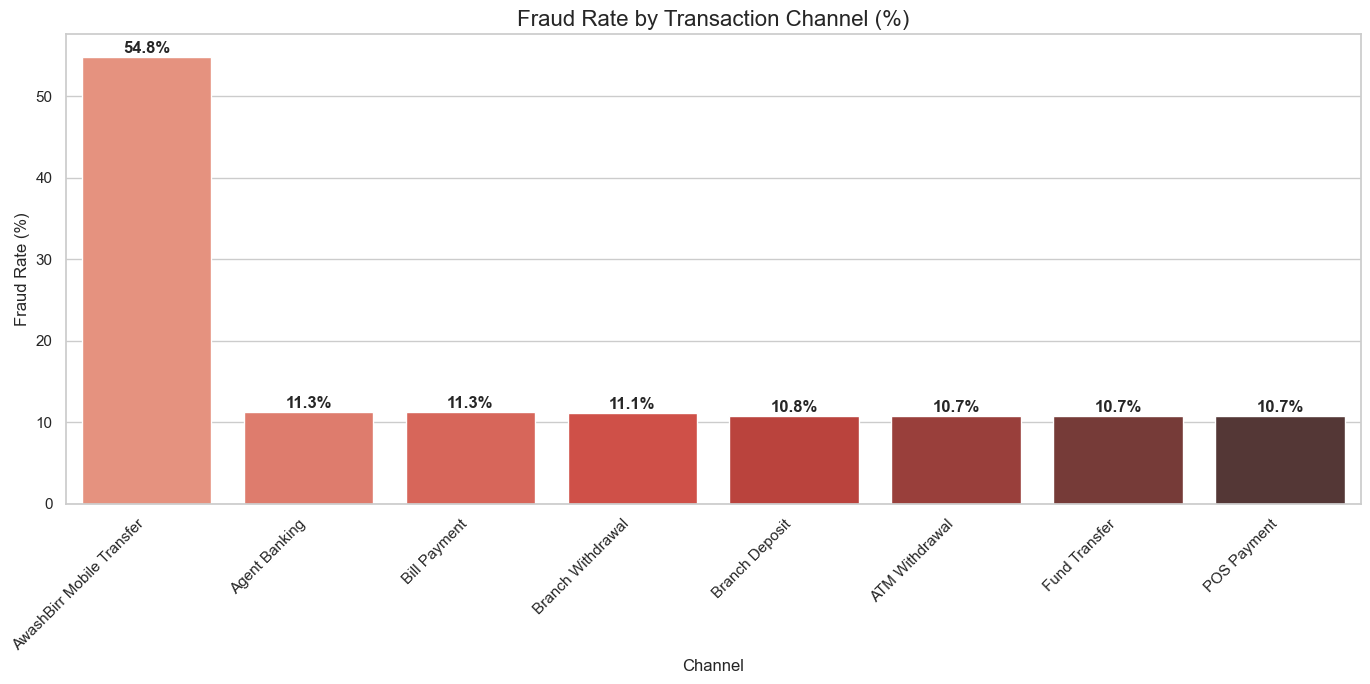

In [13]:
plt.figure(figsize=(14, 7))
channel_fraud = df.groupby('channel')['fraud_flag'].mean().sort_values(ascending=False) * 100
sns.barplot(x=channel_fraud.index, y=channel_fraud.values, palette='Reds_d')
plt.title('Fraud Rate by Transaction Channel (%)', fontsize=16)
plt.ylabel('Fraud Rate (%)')
plt.xlabel('Channel')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(channel_fraud.values):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

##### 2. Amount Distribution

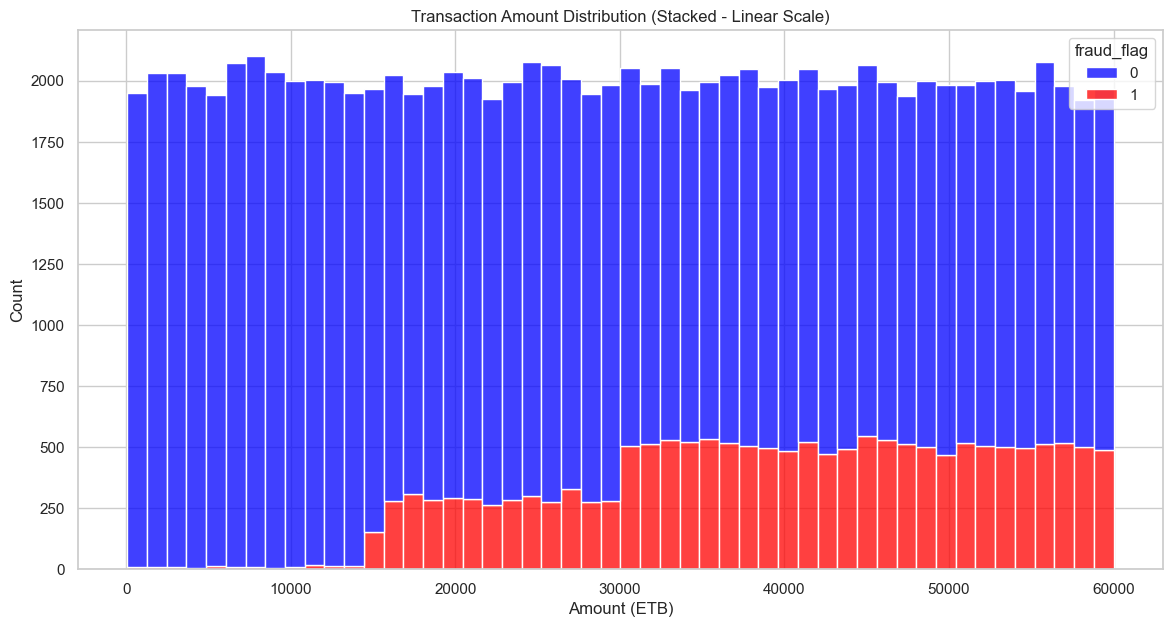

In [8]:
plt.figure(figsize=(14,7))
sns.histplot(data=df, x='amount_etb', hue='fraud_flag', bins=50, multiple='stack', palette=['blue', 'red'])
plt.title('Transaction Amount Distribution (Stacked - Linear Scale)')
plt.xlabel('Amount (ETB)')
plt.ylabel('Count')
plt.show()

##### 3. Location Mismatch vs Fraud Rate

Fraud rate when transaction location MATCHES home branch: 6.762%
Fraud rate when transaction location DOES NOT MATCH home branch: 75.144%


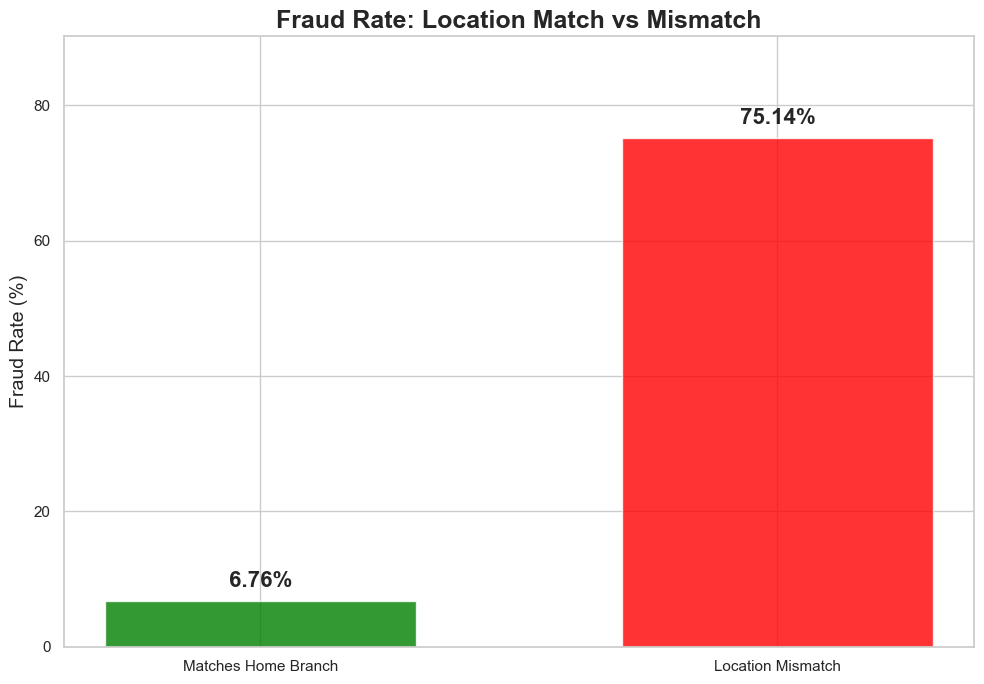


Transactions with location mismatch: 14093 (14.1%)


In [11]:
df['location_mismatch'] = (df['location'] != df['home_branch']).astype(int)

mismatch_fraud = df.groupby('location_mismatch')['fraud_flag'].mean() * 100
labels = ['Matches Home Branch', 'Location Mismatch']
values = [mismatch_fraud[0], mismatch_fraud[1]]

plt.figure(figsize=(10, 7))
bars = plt.bar(labels, values, color=['green', 'red'], alpha=0.8, width=0.6)
plt.title('Fraud Rate: Location Match vs Mismatch', fontsize=18, fontweight='bold')
plt.ylabel('Fraud Rate (%)', fontsize=14)
plt.ylim(0, max(values) * 1.2)

# Add value labels on top of bars
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.02, 
             f'{val:.2f}%', ha='center', va='bottom', fontsize=16, fontweight='bold')

print("Fraud rate when transaction location MATCHES home branch:", f"{mismatch_fraud[0]:.3f}%")
print("Fraud rate when transaction location DOES NOT MATCH home branch:", f"{mismatch_fraud[1]:.3f}%")

plt.tight_layout()
plt.show()

# Bonus: Quick stats
total_mismatch = df['location_mismatch'].sum()
print(f"\nTransactions with location mismatch: {total_mismatch} ({total_mismatch/len(df)*100:.1f}%)")

#### Feature Engineering

In [14]:
# Create features
df['hour'] = pd.to_datetime(df['date']).dt.hour
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['location_mismatch'] = (df['location'] != df['home_branch']).astype(int)
df['high_amount'] = (df['amount_etb'] > 15000).astype(int)

# One-hot encode categorical
df_encoded = pd.get_dummies(df, columns=['channel', 'account_type'], drop_first=True)

features = ['amount_etb', 'hour', 'is_weekend', 'location_mismatch', 'high_amount', 'balance_etb'] + \
           [col for col in df_encoded.columns if col.startswith(('channel_', 'account_type_'))]

X = df_encoded[features]
y = df_encoded['fraud_flag']

print(f"Features created: {len(features)}")
X.head()

Features created: 17


,amount_etb,hour,is_weekend,location_mismatch,high_amount,balance_etb,channel_Agent Banking,channel_AwashBirr Mobile Transfer,channel_Bill Payment,channel_Branch Deposit,channel_Branch Withdrawal,channel_Fund Transfer,channel_POS Payment,account_type_Diaspora Foreign Currency,account_type_Lucy Women Saving,account_type_Savings Account,account_type_Wadiah Saving (Interest-Free)
0,25020.51,8,0,0,1,235208.26,False,False,False,False,False,True,False,True,False,False,False
1,19805.13,8,0,0,1,235208.26,False,False,False,True,False,False,False,True,False,False,False
2,8073.57,8,0,0,0,235208.26,False,False,True,False,False,False,False,True,False,False,False
3,56495.12,8,0,1,1,235208.26,False,False,False,False,False,False,False,True,False,False,False
4,948.48,8,1,0,0,235208.26,False,False,True,False,False,False,False,True,False,False,False


#### Train-Test Split and Model Training

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

print("Model trained!")

Model trained!


#### Model Evaluation



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25080
           1       1.00      0.98      0.99      4920

    accuracy                           1.00     30000
   macro avg       1.00      0.99      0.99     30000
weighted avg       1.00      1.00      1.00     30000

ROC AUC Score: 0.988


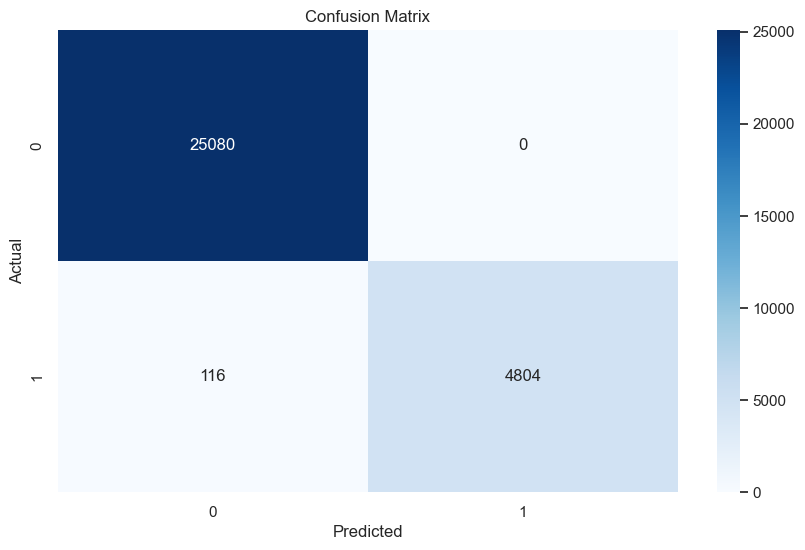

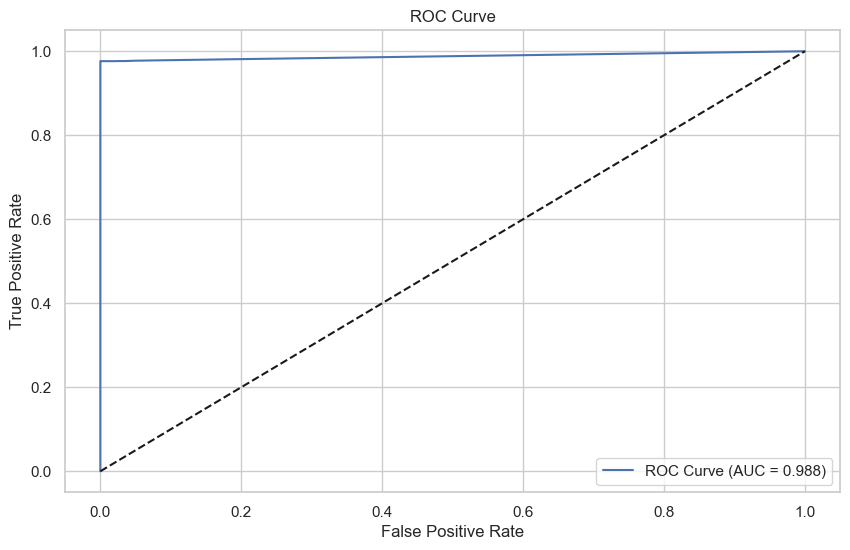

In [16]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Feature Importance

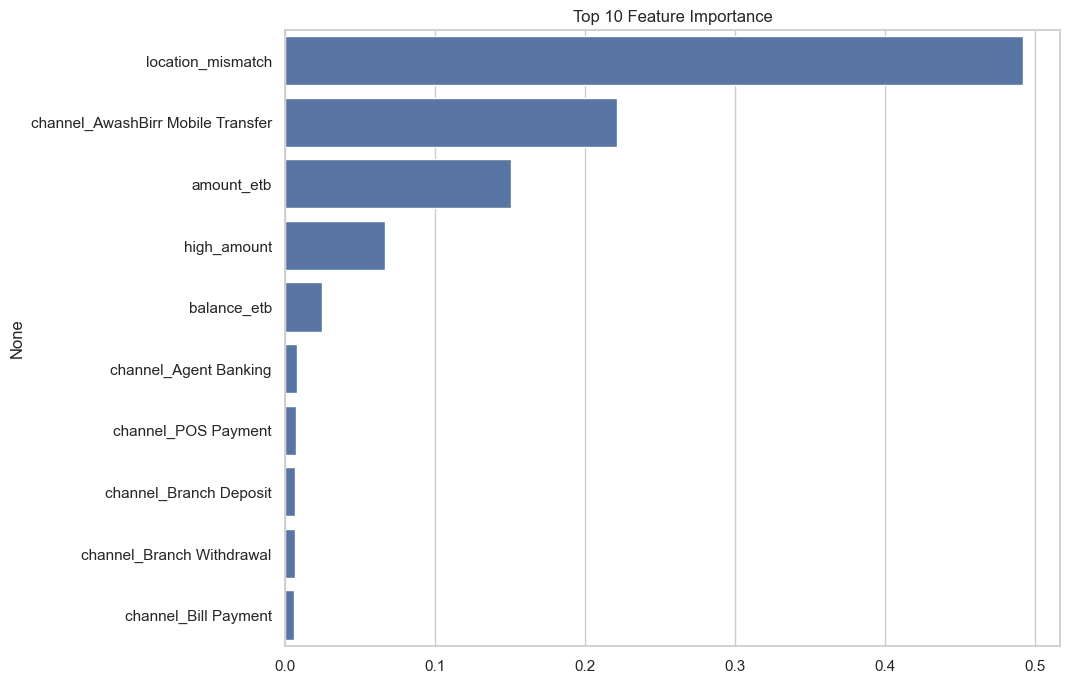

In [17]:
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10])
plt.title('Top 10 Feature Importance')
plt.show()

#### Save Model

In [18]:
joblib.dump(model, '../app/fraud_model.pkl')
joblib.dump(features, '../app/model_features.pkl')  # Save feature list for app
print("Model and features saved for Streamlit app!")

Model and features saved for Streamlit app!
